# LFSC 507 Final Project Code Submission

Analyses herein are performed on the UTIA server centaur.ag.utk.edu. Output data (of reasonable size only) is posted within the final project directory on this server and this project's github page at https://github.com/jacksonhturner/lfsc_507/tree/main/final_project. **Most code for this submission is designed to be executed through command line (bash) with requisite programs installed and is not executable on the course server**.

Directory organization of the methods used for this project is available in the <code>code</code> directory within my <code>final_project</code> folder on the course server. Large files (such as OrthoFinder results) are uploaded to the course server but are available upon request.

### Step 0: Generating Annotated Proteomes
Annotated proteomes were recovered by downloading shotgun sequencing reads from NCBI SRA using SRAtoolkit, trimming reads with cutadapt under default parameters, and assembling trimmed reads with Megahit under default parameters, and annotating assemblies with augustus using a tomato reference. Since these steps are not a focal point of this project and have been completed before the start of this course, I am not reporting code used to generate annotated proteomes. If you wish to learn more about this process, please contact me directly. 

### Step 1: Identifying Sequence Matches in Annotated Proteomes with DIAMOND
DIAMOND blastx is a fast and powerful sequence aligner used to identify sequence matches between nucleotide inputs and an amino acid reference. Annotated proteomes of Gesneriaceae samples are converted into DIAMOND databases to be used as references for sequence comparison. The following **bash script** creates DIAMOND databases from annotated proteomes and places them in an appropriate directory.

In [1]:
cd 1_proteomes; 
for FILE in *.faa; do diamond makedb -in $FILE -d ${FILE%%.diamond}; done; 
mv *.dmnd ../2_DIAMOND

SyntaxError: invalid decimal literal (2628989662.py, line 1)

Annotated proteomes are queried against DIAMOND databases to identify highly similar sequences to label as putatitive orthologs and discard. The **bash shell script** used to run DIAMOND is available in <code>2_DIAMOND/run_diamond.sh</code> and executed with the following **bash script**.

In [2]:
cd 2_DIAMOND; sh run_diamond.sh

[Errno 2] No such file or directory: '2_DIAMOND; sh run_diamond.sh'
/home/jupyter-jturne88/final_project


/opt/tljh/user/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


### Step 2: Upfront Paralog Exclusion from Annotated Proteomes with a Custom Python Script

The resulting DIAMOND sequence match tables may be used to identify loci matching to more than one gene. A custom python script was designed for this project submission to filter genes for orthologs (phylogenetically informative single-copy genes) by excluding "paralogs" (phylogenetically confounding multi-copy genes) that possess sequence matches with more than one gene. The following **python script designed to function on the course server**, displayed below, demonstrates its effectiveness upon a small test dataset. 

In [3]:
# Import pandas to load in the DIAMOND results.
import pandas as pd

# Since only the sequence headers for the query are required for this script, only the first column is necessary.
diamond_headers = ["query accession"]
# Load in the first column from the DIAMOND results.
diamond_table = pd.read_csv("../filtering_paralogs/table_subset.tsv", sep="\t",usecols=[0], names = diamond_headers)

# Conert the object into a list for easy iteration.
genes = diamond_table["query accession"].tolist()

# Create a list of all the genes in the DIAMOND results that are present only once. These sequences are only significantly similar to themselves, making them putatitve orthologs.
orthologs = []
for i in genes:
    if genes.count(i) == 1:
        orthologs.append(i)

# Find the number of genes from the DIAMOND results. 
unique_genes = list(set(genes))

# Identify and report the percentage of orthologs of all genes from the DIAMOND results.
ortholog_percent = round((len(orthologs)/len(unique_genes)),2)
print(str(ortholog_percent) + "% of genes sampled in this dataset were identified as orthologs.")

# Load in the proteome file from which ortholog sequences will be recovered and identify the file path where they will be written.
seqs = "../filtering_paralogs/Henckelia_ceratoscyphus.faa"
file_name = "../filtering_paralogs/filtered_seqs.faa"

# For each item in the list of orthologs, search for it in each sequence and add it to the designated output file. 
for i in orthologs:
    ortholog_query = str(">" + i)
    seqs_open = open(seqs, "r")
    signal = "off"
    for line in seqs_open:
        if str(line.rstrip()) == ortholog_query:
            with open(file_name, 'a') as f:
                f.write(line.strip())
                f.write("\n")
            signal = "on"
            continue
        if (signal == "on" and ">" not in line):
            with open(file_name, 'a') as f:
                f.write(line.strip())
                f.write("\n")
        if (signal == "on" and ">" in line):
            signal = "off"

# Report the number and location of written orthologs.
print(str(len(orthologs)) + " orthologs in this dataset were written to " + file_name + ".")

0.33% of genes sampled in this dataset were identified as orthologs.
13 orthologs in this dataset were written to ../filtering_paralogs/filtered_seqs.faa.


The above python script is modified slightly to iterate over all diamond sequence match tables and write filtered ortholog sequences for each. The **bash script** below executes the custom python script to filter orthologs from selected sequences.

In [3]:
cd 3_custom_script;
for FILE in *; do python ../filter_orthologs.py $FILE ${FILE%%_matches.tsv}.faa ${FILE%%_matches.tsv}_orthologs.faa; done;
cd ..

SyntaxError: invalid decimal literal (3557033954.py, line 1)

### Step 3: Custom Python Script Benchmarking Statistics

A major objective for this project is to expedite orthology inference by upfront paralog exclusion. To this end, the runtimes for each execution of the custom python script were calculated and collated. The **python script designed to function on the course server**, displayed below, performs some basic statistics upon the run times of this script and the number of orthologs recovered. The resulting figure is reported as Figure 1 featured in the final report document.

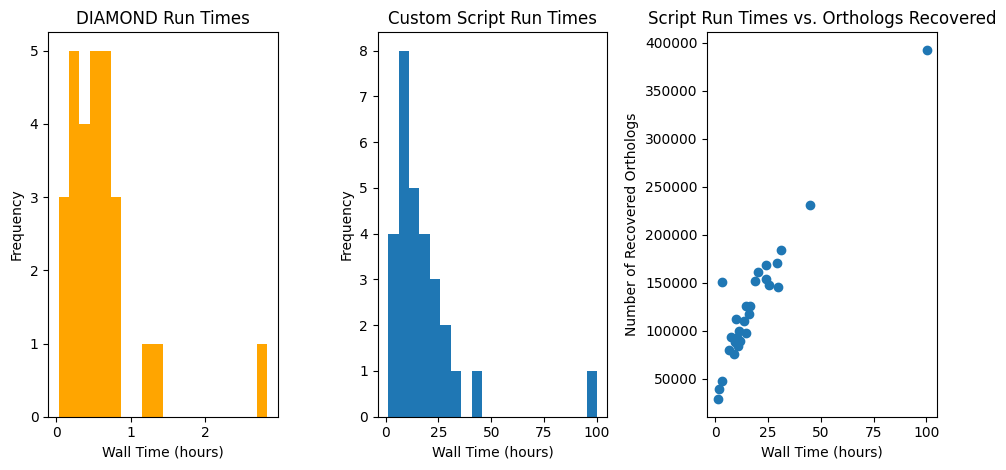

TtestResult(statistic=np.float64(-4.9876488106353225), pvalue=np.float64(6.47180471381825e-06), df=np.float64(55.0))

In [10]:
# Import packages.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import scipy

# Create a framework for the resulting matplotlib plots. 
fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=plt.figaspect(0.5))

# Read in the calculated run times DIAMOND run times .csv file, retrieve the first column only, and convert it to a list.
diamond_times = pd.read_csv("../filtering_paralogs/diamond_times.csv", sep=",",header=None)
diamond_times = list(diamond_times[1])

# Create a histogram of DIAMOND run times.
ax1.hist(diamond_times, bins = 20, color = "orange")
ax1.set_title('DIAMOND Run Times')
ax1.set_xlabel('Wall Time (hours)')
ax1.set_ylabel('Frequency')

# Read in the calculated custom python script run times and convert them to a list.
script_details = pd.read_csv("../filtering_paralogs/LFSC_507_final_project_data_sample.csv", sep=",")
script_times = list(script_details["wall_time_hours"])

# Create a histogram of custom python script run times.
ax2.hist(script_times, bins = 20)
ax2.set_title('Custom Script Run Times')
ax2.set_xlabel('Wall Time (hours)')
ax2.set_ylabel('Frequency')

# Read in the number of orthologs recovered from each sample as a list.
ogs_found = list(script_details["ogs_found"])

# Create a scatter plot to display the relationship between custom pythons cript run times and the number of recovered orthologs.
ax3.scatter(script_times,ogs_found)
ax3.set_title('Script Run Times vs. Orthologs Recovered')
ax3.set_xlabel('Wall Time (hours)')
ax3.set_ylabel('Number of Recovered Orthologs')

# Display all three plots as one figure using matplotlib.
plt.tight_layout()
plt.show()

# Calculate and report the correlation matrix of the relationship between custom python script run times and the number of recovered orthologs.
r = np.corrcoef(script_times,ogs_found)
# r = 0.94

# Perform a t-test upon the DIAMOND and custom python script run times to determine if a significant difference exists between the two and report the results.
st.ttest_ind(diamond_times,script_times)
# p = 6.47e-6


### Step 4: Orthology Inference

Orthology inference was conducted upon the recovered set of amino acid filtered ortholog sequences using OrthoFinder under default conditions using 15 cores. The **bash script** used to execute orthology inference is displayed below.

In [ ]:
cp 3_custom_py_script *orthologs.faa 4_OrthoFinder;
ulimit -n 10000 # Increase the number of openable files to prevent OrthoFinder from crashing
orthofinder -f 4_OrthoFinder -t 15

### Step 5: Phylogenomics Pipeline

OrthoFinder results were used to harvest single copy genes orthologous in 90% of taxa using a custom python script (orthofinder_finder.py, developed prior to this course by Dr. Ryan Kuster). I do not review this code for this project submission since it was not written by me, but it is available within this project directory for perusal. Final orthologs recovered in this way are then aligned with MAFFT under default parameters, and masked with trimAl under default parameters with a 40% missing data threshold. a Maximum Likelihood phylogenetic tree is created from aligned, masked sequences using a suite of settings optimized for the retrieval of an accurate phylogeny. These settings used for tree inference are described in more detail in the final report document. The following **bash script** details the execution of this phylogenomics pipeline.

In [ ]:
cd 2_DIAMOND;
python orthofinder_finder.py ../4_OrthoFinder/Results_Dec04 0.9 4_OrthoFinder 5_phylogenomics_pipeline/1_recovered_orthologs 0;
cd 5_phylogenomics_pipeline/1_recovered_orthologs;
for FILE in *.faa; do mafft $FILE > ../2_mafft; done;
cd ../2_mafft; 
for FILE in *.mafft; do trimal -in $FILE -out ../3_trimal/$FILE -gt .4; done;
cd ..;
iqtree2 -p 3_trimal -m MFP+MERGE -B 1000 -rcluster 10 -bnni -nt AUTO;
mv 3_trimal.* 4_iqtree

### Step 6: Benchmarking for OrthoFinder Run Time and Phylogenetic Accuracy

Orthofinder run time was recorded and compared with a run constructed from identical sequences and pipeline steps excluding the number of cores utilized (15 for this project vs 8 for the alternate) and the type of input sequences provided (amino acid only for this projects vs amino acid and nucleotide sequences for the alternate). Run times for each, including standardized (for 8 cores) and nonstandardized run times for paralog exclusion steps, are visualized using a **python script designed to function on the course server** below. The resulting figure is reported as Figure 2 featured in the final report document.

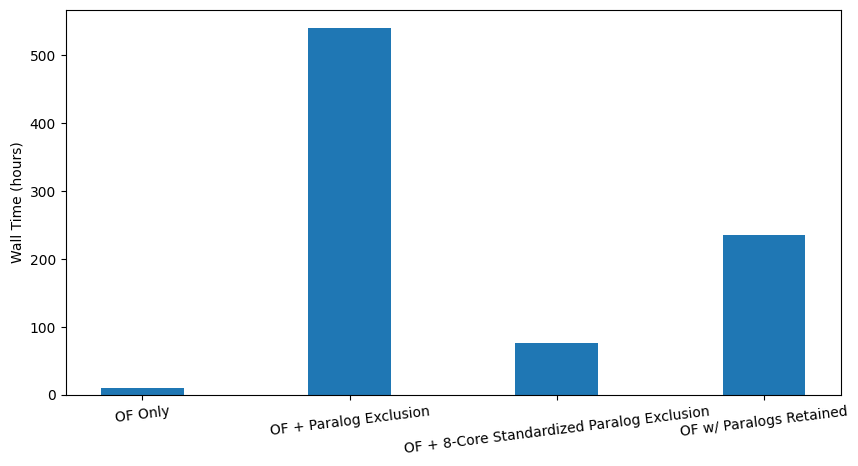

In [18]:
### python code goes here
import matplotlib.pyplot as plt

OF_only_hours = 10.25
full_run_hours = 539.216667
eight_core_standardized_run_hours = OF_only_hours + (full_run_hours-OF_only_hours)/8 # = 76.37
benchmark_run_hours = 234.633333

OF_runtime_benchmarking = {"OF Only":10.25, 
                           "OF + Paralog Exclusion":539.22, 
                           "OF + 8-Core Standardized Paralog Exclusion":76.37,
                           "OF w/ Paralogs Retained":234.63}
procedures = list(OF_runtime_benchmarking.keys())
run_times = list(OF_runtime_benchmarking.values())

OF_benchmarking_plot = plt.figure(figsize = (10, 5))

# creating the bar plot
plt.bar(procedures, run_times,
        width = 0.4)

plt.ylabel("Wall Time (hours)")
plt.xticks(rotation = 7)
plt.show()

Phylogenetic accuracy of the recovered ML phylogeny was benchmarked against the result tree from the software pipeline mentioned above and a reference phylogeny from Yang et al. (2021) using this dataset. Robinson-Foulds distances of phylogenies were used to compare and visualize their accuracies using a **custom R script**, <code>LFSC_507_phylogenetic_accuracy_comparisons.R</code>. The code used for this exercise is available below. A side-by-side comparison of the topology recovered from the custom paralog exclusion method implemented here and the reference topology provided by Yang et al. is constructed using this script and available at <code>LFSC_507_final_phylogeny.png</code>. The resulting figure is reported as Figure 4 featured in the final report document.

In [8]:
# This script loads in benchmarking trees and uses them to generate Jaccard Robinson-Foulds distances.

setwd("C:/Users/jturn")
library(ape)
library(phangorn)
library(TreeDist)

# Reference Topology (recovered from Study et al. 2020)

ges_ref <- read.tree("henckelia_skeleton.treefile")
ges_ref <- root(ges_ref,"Ornithoboea_henryi")
ges_ref$edge.length = ges_ref$edge.length * 20

# Phylogeny after ortholog filtering
LFSC_ges <- read.tree("LFSC_final_phylogeny.treefile")
LFSC_ges <- root(LFSC_ges,"Ornithoboea_henryi")
JaccardRobinsonFoulds(LFSC_ges, ges_ref)
# R-F score: 7.09
VisualizeMatching(RobinsonFouldsMatching,LFSC_ges,ges_ref)

SyntaxError: invalid syntax (128594919.py, line 12)

### Closing Remarks

This notebook file intends to provide an overview of code executed for the LFSC 507 final project submission and is not exhaustive. Please review the final report document for more information on analyses and the interpretation of results or reach out to me directly. Thank you for your time reviewing this code submission Jupyter notebook.